# Model results viewer

In [1]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchsampler import ImbalancedDatasetSampler
import json
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
import random
import copy
import io
import cv2
from utils.model_utils import *
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

%matplotlib inline


# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

PyTorch Version:  1.13.1+cu117
Torchvision Version:  0.14.1+cu117
cuda:0


**Load images data**

In [2]:
flaw = "FRM"

In [3]:
# Data path
file = f'../data/vw_{flaw}_dataset.json'

# Load data
with open(file, encoding='UTF-8') as m_json_file:
    data = json.load(m_json_file)
    mc_test_data = np.array(data["test"], dtype=object)
    mc_train_data = np.array(data["train"], dtype=object)
    mc_val_data = np.array(data["val"], dtype=object)
    
dataset_size = len(mc_test_data) + len(mc_val_data) + len(mc_train_data)
multiclass = True if "mc" in file.lower() else False
    
# Load transformation data
train_dir = '/media/arnau/SSD/VizWiz/models/multiclass/train/'
norm_path = f'../outputs/norms_{flaw}.pkl'
input_size = (224,224)
data_transforms = get_transforms(norm_path, input_size, train_dir, 
                                 mc_train_data, multiclass=multiclass, typ=flaw)

# Prepare test val
test_dir = '/media/arnau/SSD/VizWiz/data/captioning/val/'
test_dataset = ImageDataset(test_dir, mc_test_data, data_transforms["val"], 
                            multiclass=multiclass)
test_loader = DataLoader(test_dataset, batch_size=32, 
                         num_workers=0, pin_memory=True,
                          sampler=ImbalancedDatasetSampler(test_dataset))

In [4]:
print(f"Dataset size: {dataset_size}")
print(f"Test set size: {len(test_dataset)}, {(len(test_dataset) / dataset_size) * 100:.2f}%")

Dataset size: 5664
Test set size: 552, 9.75%


## Results

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [6]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

def plot_aoc_roc_curve(y_true, y_pred):
    # Calculate AUC-ROC score and ROC curve using sklearn
    auc_roc = roc_auc_score(y_true, y_pred, multi_class='ovr')
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, multi_class='ovr')

    # Plot ROC curve
    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_roc))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    
def plot_confusion_matrix(cm, classes):
    """
    This function plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()

    
def evaluate(model, loss_fn, test_loader, device):
    """
    Evaluate the model on the test set
    """
    
    model.eval()

    test_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        
        if not multiclass:
            outputs = outputs.float()
            targets = targets.unsqueeze(1).float()
   
        loss = loss_fn(outputs, targets)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        if not multiclass:
            predicted = torch.round(torch.sigmoid(outputs))
        correct += torch.sum(predicted == targets.data)
        y_true += targets.cpu().numpy().tolist()
        y_pred += predicted.cpu().detach().numpy().tolist()

    test_loss /= len(test_loader.dataset)
    test_acc = correct / total
    test_f1 = f1_score(y_true, y_pred, average='weighted')
    test_precision = precision_score(y_true, y_pred, average='weighted')
    test_recall = recall_score(y_true, y_pred, average='weighted')

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc * 100:.2f}%")
    print(f"Test F1 Score: {test_f1 * 100:.2f}%")
    print(f"Test Precision: {test_precision * 100:.2f}%")
    print(f"Test Recall: {test_recall * 100:.2f}%")

    cm = confusion_matrix(y_true, y_pred)
    
    return y_true, y_pred, cm

**Results on test set**

**NOTE**: Thanks to previous preprocessing, test sat does not contain images from val set.

In [7]:
# Load model
save_path = f'../outputs/best_{flaw}_convnext.pth'
num_classes = len(mc_train_data[:, 1::][0])
model, input_size = initialize_model(num_classes, "convnext")
model = model.to(device)
model.load_state_dict(torch.load(save_path))

if multiclass:
    loss_fn = nn.CrossEntropyLoss()
else:
     loss_fn = nn.BCEWithLogitsLoss()

Test Loss: 0.4412
Test Accuracy: 79.17%
Test F1 Score: 79.06%
Test Precision: 79.46%
Test Recall: 79.17%


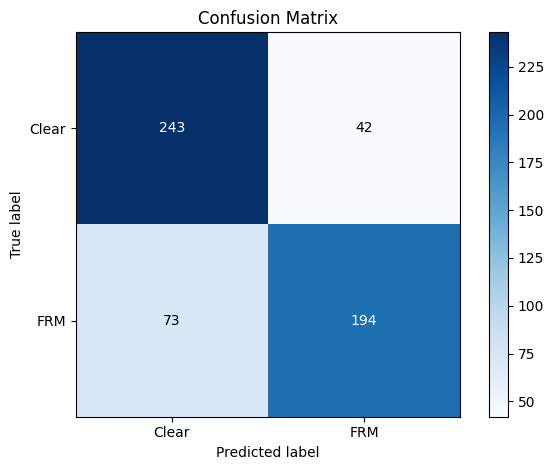

In [8]:
class_labels = ['Clear', 'BLR', 'FRM', 'BLR+FRM'] if multiclass == True else ['Clear', flaw]

yt, yp, cm = evaluate(model, loss_fn, test_loader, device)

#plot_aoc_roc_curve(yt, yp)
#num_params = count_parameters(model)
#print(f"Number of trainable parameters in the model: {num_params}")
plot_confusion_matrix(cm, classes=class_labels)

In [9]:
def inference(i):
    """
    Model outputs 1 if the image is blurred otherwise 0
    """
    
    img = Image.open(i)

    transform = transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.ToTensor(),        
    ])

    img_tensor = transform(img).unsqueeze(0).to(device)

    model.eval()

    with torch.no_grad():
        output = model(img_tensor)

    _, predicted = torch.max(output.data, 1)
    #predicted = torch.round(torch.sigmoid(output))
    pred = predicted.cpu().detach().numpy()[0]
    
    return pred

**Inference visualization**

Visualization of how the model performs

Model: Clear
True: FRM


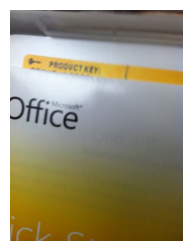

Model: Clear
True: FRM


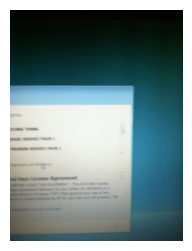

Model: Clear
True: FRM


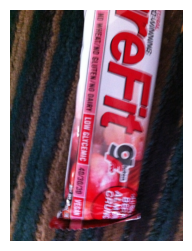

Model: Clear
True: Clear


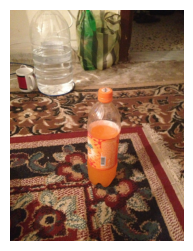

Model: Clear
True: Clear


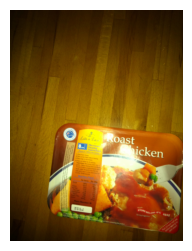

In [10]:
ten_random_imgs = random.choices(mc_test_data, k=5)

if multiclass:
    labels_names = {0 : "Clear", 1 : "BLR", 2 : "FRM", 3: "BLR + FRM"}
else:
    labels_names = {0 : "Clear", 1 : flaw}

for i, data in enumerate(ten_random_imgs):
    plt.figure(figsize=(3, 3))
    img_name = data[0]
    if multiclass:
        label = np.where(data[1::] == 1)[0][0]
    else:
        label = data[1]
    img = test_dir + img_name
    model_pred = inference(img)
    model_pred = labels_names[model_pred]
    print(f"Model: {model_pred}")
    true_label = labels_names[label]
    print(f"True: {true_label}")
    img = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    img = (img.astype(np.float32) / np.max(img) * 255).astype(np.uint8)
    plt.imshow(img)
    plt.axis('off')
    plt.show()